Fitting 5 folds for each of 90 candidates, totalling 450 fits
Mejores parámetros (clasificador): {'model__criterion': 'entropy', 'model__max_depth': 3, 'model__min_samples_leaf': 2, 'model__min_samples_split': 2}
ROC AUC CV: 0.993023481983365
Precision CV: 0.9885312615612282
Recall CV: 0.9808417997097243
F1 CV: 0.9845389029398166

Classification report (test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       1.00      0.98      0.99        66

    accuracy                           0.99       147
   macro avg       0.99      0.99      0.99       147
weighted avg       0.99      0.99      0.99       147

Confusion matrix:
[[81  0]
 [ 1 65]]
ROC AUC (test): 0.9987841376730265


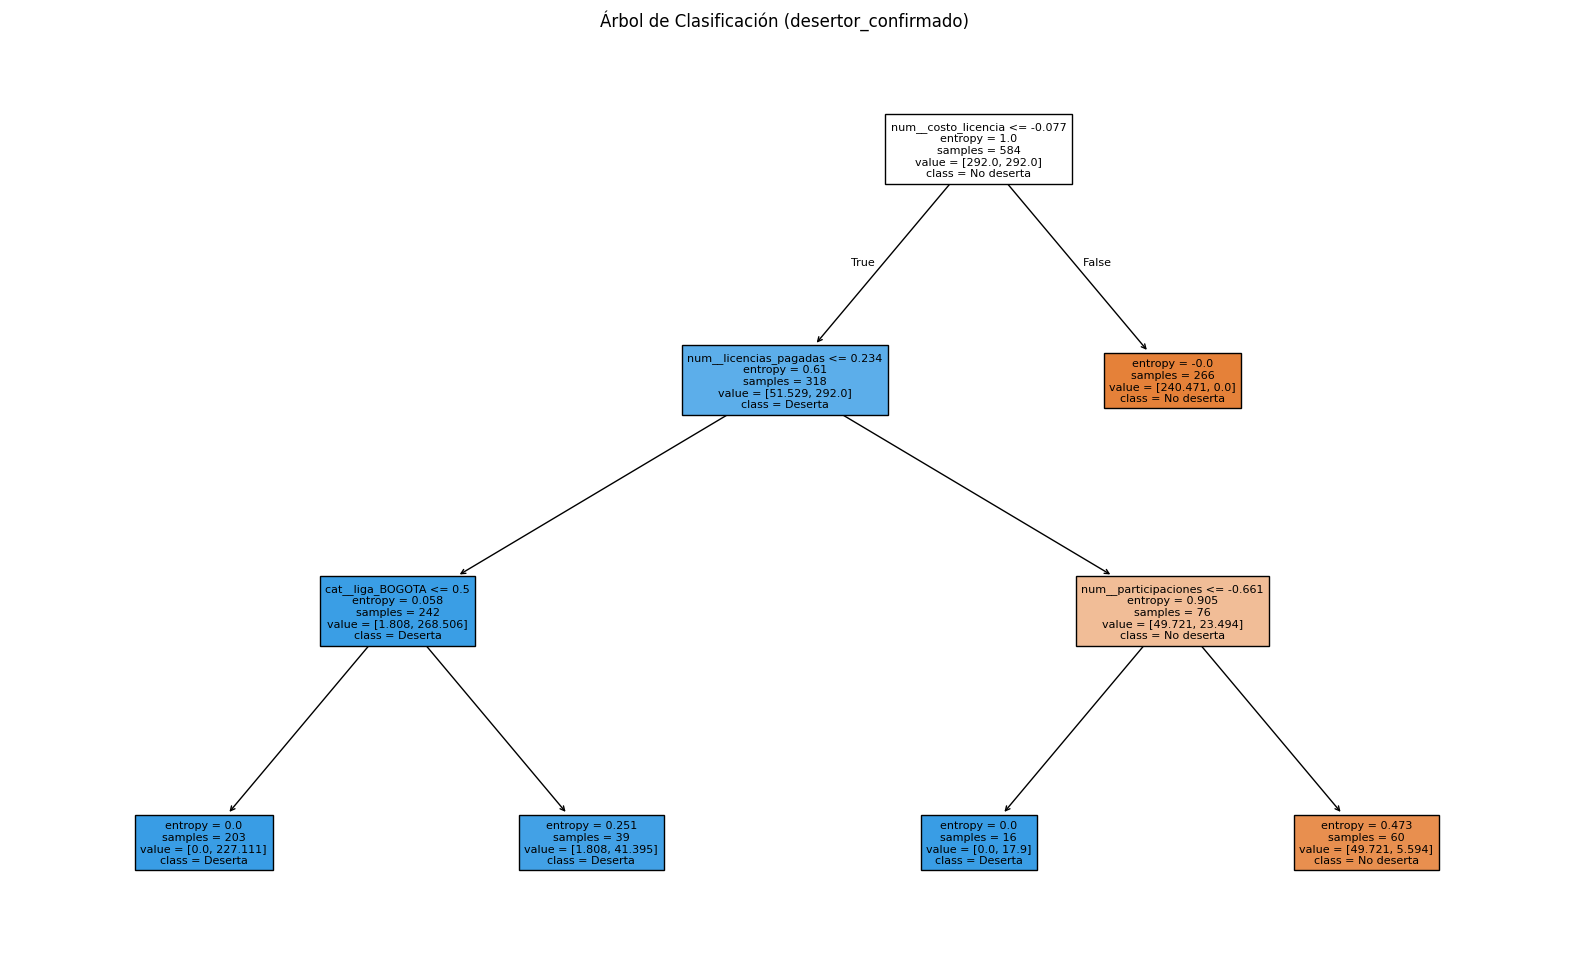

In [15]:
# === Librerías (añadir si no están) ===
from google.cloud import bigquery
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import (confusion_matrix, classification_report,
                             roc_auc_score, precision_score, recall_score, f1_score)
import matplotlib.pyplot as plt

# === Cargar datos ===
client = bigquery.Client()
query = """
SELECT * FROM `instant-bonbon-474722-g7.Resultados_Pruebas_Mayores.Analisis_Desercion_v2`
"""
df = client.query(query).to_dataframe()
df = df.drop(columns=['fecha_nacimiento','ultimo_año_participacion'])

# === Target booleano ===
target = 'desertor_confirmado'   # <-- variable booleana que mencionas
X = df.drop(columns=[target])
y = df[target].astype(int)       # asegurar 0/1

# === Columnas ===
cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['float64', 'int64', 'Int64']).columns.tolist()

# === Preprocesamiento con imputación ===
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])

# === Pipeline con DecisionTreeClassifier ===
pipe_clf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
])

# === Train-test split (estratificado para conservar proporción clases) ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# === GridSearchCV para clasificación ===
param_grid_clf = {
    'model__max_depth': [3, 5, 7, 10, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
    'model__criterion': ['gini', 'entropy']
}

# usar StratifiedKFold en CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_clf = GridSearchCV(
    pipe_clf,
    param_grid_clf,
    cv=skf,
    scoring='roc_auc',   # métrica principal para imbalanced
    n_jobs=-1,
    verbose=1
)
grid_clf.fit(X_train, y_train)

print("Mejores parámetros (clasificador):", grid_clf.best_params_)

# === Validación cruzada con varias métricas ===
scoring = {
    'roc_auc': 'roc_auc',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1'
}
cv_results = cross_validate(grid_clf.best_estimator_, X_train, y_train, cv=skf, scoring=scoring)
print("ROC AUC CV:", cv_results['test_roc_auc'].mean())
print("Precision CV:", cv_results['test_precision'].mean())
print("Recall CV:", cv_results['test_recall'].mean())
print("F1 CV:", cv_results['test_f1'].mean())

# === Evaluación final en test ===
best_clf = grid_clf.best_estimator_
y_pred = best_clf.predict(X_test)
y_proba = best_clf.predict_proba(X_test)[:, 1] if hasattr(best_clf.named_steps['model'], "predict_proba") else None

print("\nClassification report (test):")
print(classification_report(y_test, y_pred))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

if y_proba is not None:
    print("ROC AUC (test):", roc_auc_score(y_test, y_proba))
else:
    print("ROC AUC no disponible (modelo no tiene predict_proba)")

# === Mostrar árbol (opcional, con nombres de features) ===
best_tree = best_clf.named_steps['model']
feature_names = best_clf.named_steps['preprocessor'].get_feature_names_out()
plt.figure(figsize=(20,12))
plot_tree(best_tree,feature_names=feature_names,
    class_names=['No deserta', 'Deserta'], filled=True, fontsize=8)
plt.title("Árbol de Clasificación (desertor_confirmado)")
plt.show()


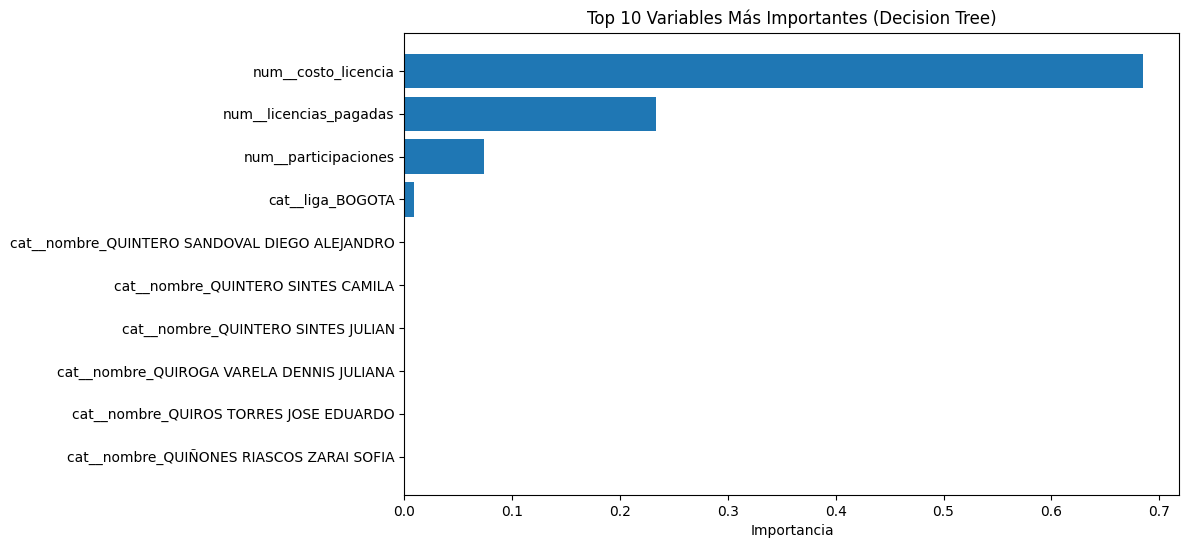

In [10]:
# === Gráfica de Importancia de Variables (Top 10) ===
importances = best_tree.feature_importances_
feature_names = best_clf.named_steps['preprocessor'].get_feature_names_out()

# Crear DataFrame ordenado
feat_imp = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Tomar solo el top 10
top10 = feat_imp.head(10)

# Graficar
plt.figure(figsize=(10, 6))
plt.barh(top10['feature'], top10['importance'])
plt.gca().invert_yaxis()  # la más importante arriba
plt.title("Top 10 Variables Más Importantes (Decision Tree)")
plt.xlabel("Importancia")
plt.show()



Fitting 5 folds for each of 108 candidates, totalling 540 fits
Mejores parámetros (Random Forest):
{'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__n_estimators': 100}

=== Resultados CV (Random Forest) ===
ROC AUC CV: 0.9985702523166239
Precision CV: 0.9744107744107744
Recall CV: 0.9884615384615385
F1 CV: 0.9809746406957158

=== Classification report (test) - Random Forest ===
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        81
           1       1.00      0.98      0.99        66

    accuracy                           0.99       147
   macro avg       0.99      0.99      0.99       147
weighted avg       0.99      0.99      0.99       147

Confusion matrix:
[[81  0]
 [ 1 65]]
ROC AUC (test): 1.0


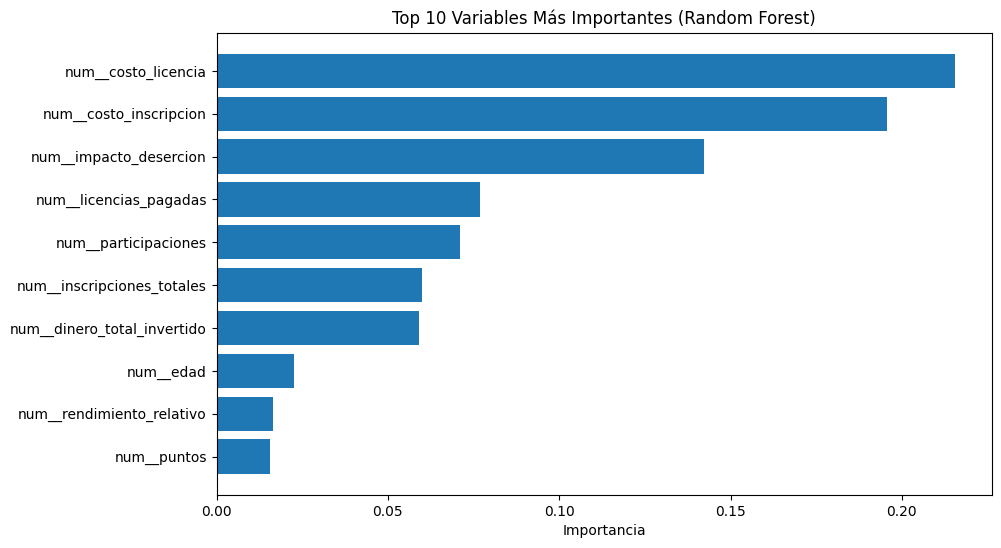

In [11]:
# ============================================================
# === Random Forest===
# ============================================================

from sklearn.ensemble import RandomForestClassifier

# === Crear una nueva pipeline reutilizando el preprocessor ===
pipe_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(
        random_state=42,
        class_weight="balanced",
        n_jobs=-1
    ))
])

# === GridSearch para RandomForest ===
param_grid_rf = {
    'model__n_estimators': [100, 200, 300],
    'model__max_depth': [5, 10, 15, None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4]
}

grid_rf = GridSearchCV(
    pipe_rf,
    param_grid_rf,
    cv=skf,               # El mismo StratifiedKFold de arriba
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train, y_train)

print("Mejores parámetros (Random Forest):")
print(grid_rf.best_params_)

# === Validación cruzada con métricas ===
cv_results_rf = cross_validate(
    grid_rf.best_estimator_,
    X_train,
    y_train,
    cv=skf,
    scoring=scoring
)

print("\n=== Resultados CV (Random Forest) ===")
print("ROC AUC CV:", cv_results_rf['test_roc_auc'].mean())
print("Precision CV:", cv_results_rf['test_precision'].mean())
print("Recall CV:", cv_results_rf['test_recall'].mean())
print("F1 CV:", cv_results_rf['test_f1'].mean())

# === Evaluación en el conjunto de prueba ===
best_rf = grid_rf.best_estimator_
y_pred_rf = best_rf.predict(X_test)
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]

print("\n=== Classification report (test) - Random Forest ===")
print(classification_report(y_test, y_pred_rf))

print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred_rf))

print("ROC AUC (test):", roc_auc_score(y_test, y_proba_rf))

# =============================================================
# === Top 10 Feature Importances (Random Forest) ===============
# =============================================================

rf_model = best_rf.named_steps['model']
feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()

feat_imp_rf = pd.DataFrame({
    'feature': feature_names,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

top10_rf = feat_imp_rf.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top10_rf['feature'], top10_rf['importance'])
plt.gca().invert_yaxis()
plt.title("Top 10 Variables Más Importantes (Random Forest)")
plt.xlabel("Importancia")
plt.show()


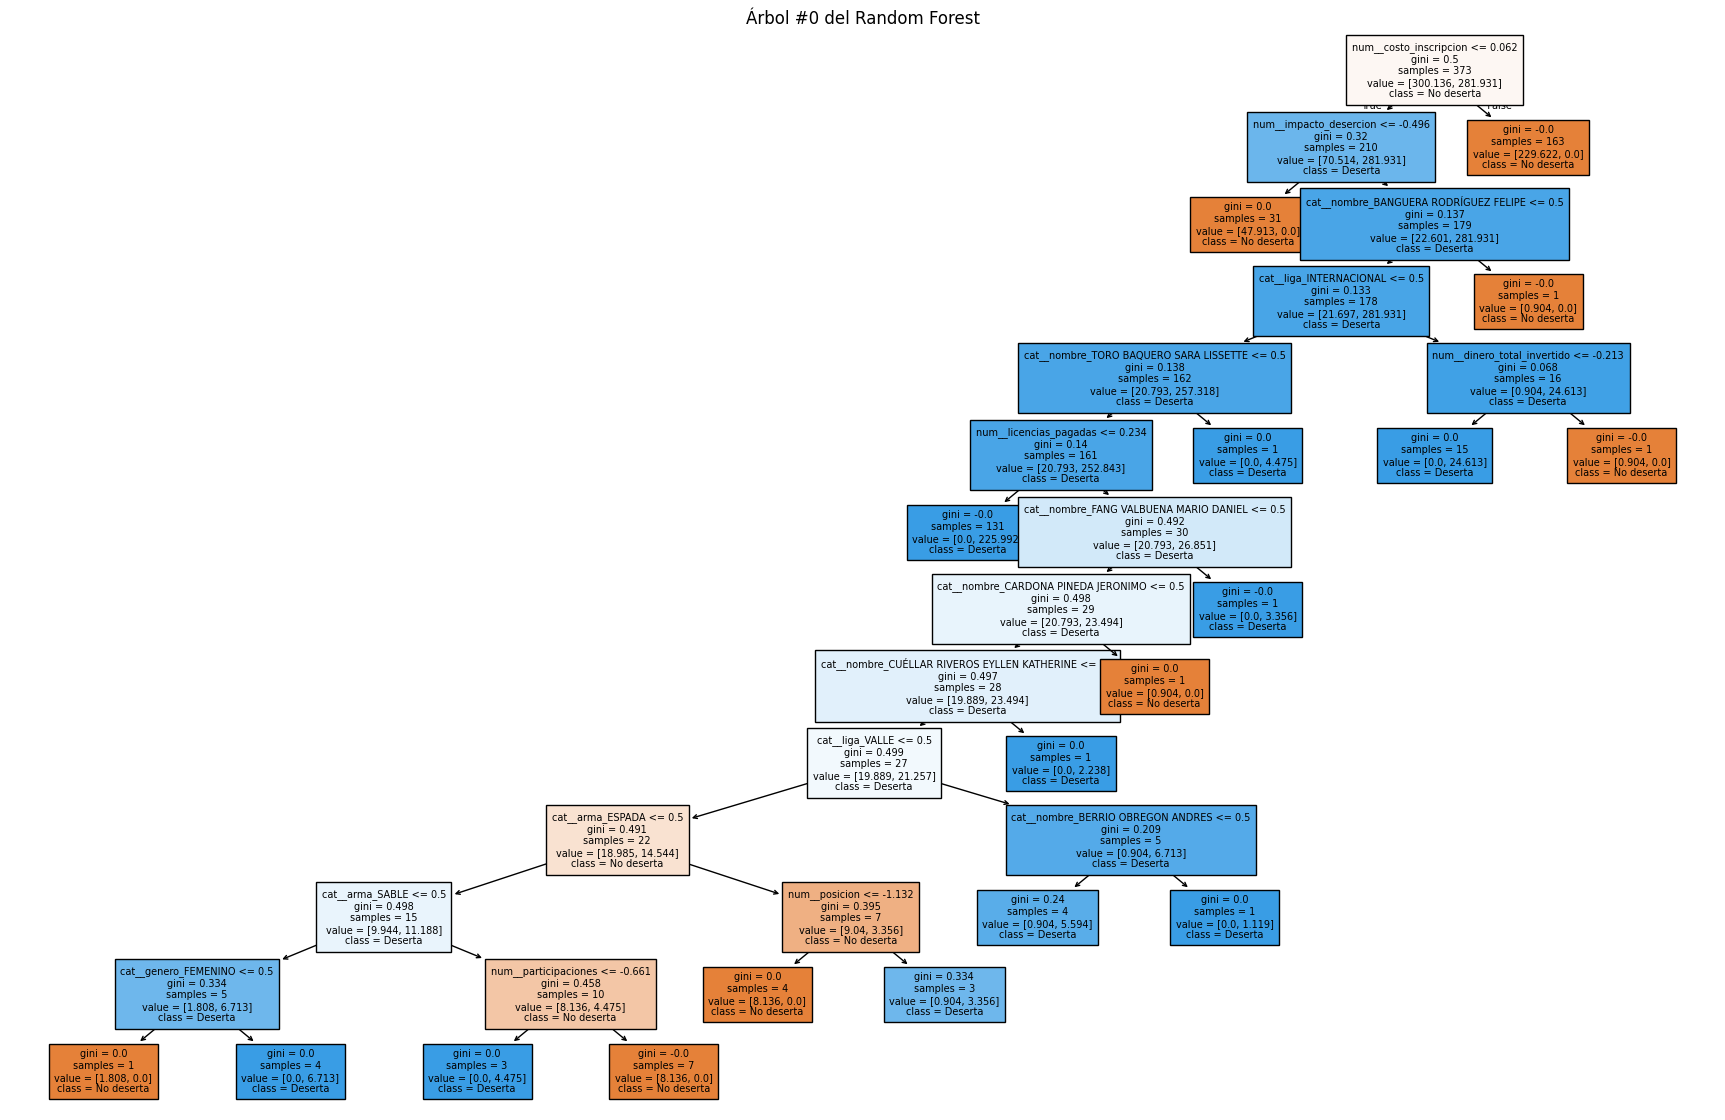

In [14]:
# === Plotear uno de los árboles del Random Forest ===
rf_model = best_rf.named_steps['model']
feature_names = best_rf.named_steps['preprocessor'].get_feature_names_out()

# Seleccionar un árbol del bosque
tree_id = 0  # puedes cambiarlo a otro número para ver distintos árboles
selected_tree = rf_model.estimators_[tree_id]

plt.figure(figsize=(22, 14))
plot_tree(
    selected_tree,
    feature_names=feature_names,
    class_names=['No deserta', 'Deserta'],
    filled=True,
    fontsize=7
)
plt.title(f"Árbol #{tree_id} del Random Forest")
plt.show()

